<a href="https://colab.research.google.com/github/ryanlandvater/qIS/blob/main/QuantImmunoSubtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantitative Immuno-Subtraction Project
---


In [1]:
# %matplotlib notebook
import sys                as sys
import pandas             as pd               #import pandas for file reading
import matplotlib         as mpl              #import matplotlib for graphing
import matplotlib.pyplot  as plt              #import plot module
import numpy              as np               #import numpy for arithmetic fns

import IPython                                #import IPhython for settings
from IPython  import display as dsp           #import IPython desplay
# from dsp      import clear_output             #import clear output for dynamics
dsp.set_matplotlib_formats('svg')             # Create vector plots

print("Using Pandas to import data version:\t" + pd.__version__);
# print("Plotting with MatPlotLib version:\t" + mpl.__version__);
print("Using numpy version:\t\t\t" + np.__version__);



Using Pandas to import data version:	1.1.5
Using numpy version:			1.19.5


## Ryan's Curve Fit Playground
---
Begin by defining the relevant functions for non-linear least-squared curve fitting using the Newton-Gauss Method.






### Defining the Partial Differential Equations
1.   Normal / Gaussian distribution ($\rho$):
$$ \rho = \frac{\alpha e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi}\sigma} \  \text{where} \  
\begin{aligned} 
& \alpha = \text{amplitude} \\
& \mu = \text{mean} \\
& \sigma = \text{standard deviation}
\end{aligned}$$ 
2.   Residuals $r$ for $y$ discrete readings $\left[0\dots N\right]$ taken at locations $x$ ($y_x$)
$$ r_x = \frac{1}{2}\left( y_x - \frac{\alpha e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi}\sigma}\right)^2\\
r_x = \left[r_0,r_1,r_2,\dots,r_N\right]$$ 
3.   Differentials of residuals with respect to normal distribution parameters:
  1. Partial with respect to the amplitude
$$ 
\frac{\partial r_x}{\partial \alpha} = 
\frac{\partial r_x}{\partial \rho_x}\frac{\partial \rho_x}{\partial \alpha} = 
-\frac{e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi}\sigma}\cdot  
\left(y_x-\frac{\alpha e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi}\sigma}\right) \\
\frac{\partial r_x}{\partial \alpha} =  \left[\frac{\partial r_0}{\partial \alpha},\frac{\partial r_1}{\partial \alpha},\frac{\partial r_2}{\partial \alpha},\dots,\frac{\partial r_N}{\partial \alpha}\right] $$
  2. Partial with respect to the mean
$$
\frac{\partial r_x}{\partial \mu} = \frac{\partial r_x}{\partial \rho_x}\frac{\partial \rho_x}{\partial \mu} = -\frac{\alpha(x-\mu)e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi}\sigma^3}\cdot  
\left(y_x-\frac{\alpha e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi}\sigma}\right) \\
\frac{\partial r_x}{\partial \mu} =  \left[\frac{\partial r_0}{\partial \mu},\frac{\partial r_1}{\partial \mu},\frac{\partial r_2}{\partial \mu},\dots,\frac{\partial r_N}{\partial \mu}\right] $$
  3. Partial with respect to the standard deviation
$$
\frac{\partial r_x}{\partial \sigma} = \frac{\partial r_x}{\partial \rho_x}\frac{\partial \rho_x}{\partial \sigma} =
\left(\frac{\alpha e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi}\sigma^2}-\frac{a(x-m)^2 e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi}\sigma^4}\right) \cdot 
\left(y_x-\frac{\alpha e^{\frac{-(x-\mu)^2}{2\sigma^2}}}{\sqrt{2\pi}\sigma}\right) \\
\frac{\partial r_x}{\partial \sigma} =  \left[\frac{\partial r_0}{\partial \sigma},\frac{\partial r_1}{\partial \sigma},\frac{\partial r_2}{\partial \sigma},\dots,\frac{\partial r_N}{\partial \sigma}\right] $$


In [2]:
# param[0] = AMPLITUDE
# param[1] = MEAN
# param[2] = STANDARD DEVIATION
def conv_norm_dist(x,p):
  result = [0] * len(x)
  for p_ in p:
    result += p_[0]*np.exp(-pow((x-p_[1]),2)/(2*pow(p_[2],2))) / (np.sqrt(2*np.pi)*p_[2])
  return result
def norm_dist(x, p):
  result = []
  for p_ in p:
    result.append(p_[0]*np.exp(-pow((x-p_[1]),2)/(2*pow(p_[2],2))) / (np.sqrt(2*np.pi)*p_[2]))
  return result
def d_norm_dist_d_amp(x, p):
  result=[]
  for p_ in p:
    result.append(np.exp(-pow((x-p_[1]),2)/(2*pow(p_[2],2))) / (np.sqrt(2*np.pi)*p_[2]))
  return result
def d_norm_dist_d_mean(x, p):
  result=[]
  for p_ in p:
    result.append(p_[0]*(x-p_[1])*np.exp(-pow(x-p_[1],2)/(2*pow(p_[2],2)))/(np.sqrt(2*np.pi)*pow(p_[2],3)))
  return result
def d_norm_dist_d_sd(x, p):
  result=[]
  for p_ in p:
    result.append((p_[0]*pow(x-p_[1],2)*np.exp(-pow(x-p_[1],2)/(2*pow(p_[2],2)))/(np.sqrt(2*np.pi)*pow(p_[2],4)))
    -(p_[0]*np.exp(-pow(x-p_[1],2)/(2*pow(p_[2],2))) / (np.sqrt(2*np.pi)*pow(p_[2],2))))
  return result
# Residuals return two 
def residuals(y, x, p):
  return 1/2 * pow(y - conv_norm_dist(x,p),2)
# dR/dRho returns 
def d_r_d_rho(y,x,params = [3]):
  return y - norm_dist(x, params)
def d_r_d_amp(y,x, params = [3]):
  return -1 * d_r_d_rho(y,x,params) * d_norm_dist_d_amp(x,params)
def d_r_d_mean(y,x, params = [3]):
  return -1 * d_r_d_rho(y,x,params) * d_norm_dist_d_mean(x,params)
def d_r_d_sd(y,x,params = [3]):
  return -1 * d_r_d_rho(y,x, params) * d_norm_dist_d_sd(x,params)

# NUMERICAL DERIVATIVES
def num_d_r_d_amp(y,x, params = [3]):
  step    = params
  results = []
  for i in range(len(step)):
    step[i][0] += 1
    results.append(residuals(y,x,[step[i]]) - residuals(y,x,[params[i]]))
  return results
def num_d_r_d_mean(y,x, params = [3]):
  return residuals(y,x,amp,mean+1,sd) - residuals(y,x,params)
def num_d_r_d_sd(y,x, params = [3]):
  return residuals(y,x,amp,mean,sd+1) - residuals(y,x,params)

### Class Declarations
---
The following code incapsulates the above functions in an object-oriented manner to provide greater ease of use.

In [3]:
class curve:
  amp = 1.0
  mean = 1.0
  sd = 1.0
  def __init__(self, init_amp,  init_mean, init_sd):
    self.amp  = init_amp
    self.mean = init_mean
    self.sd   = init_sd
  # Generate a normal distribution using the curves parameters
  def normal_dist(self, x):
    return self.amp*np.exp(-pow((x-self.mean),2)/(2*pow(self.sd,2))) / (np.sqrt(2*np.pi)*self.sd)
  # Mathematical differentials
  def dR_dRho (self, x, y):
    return y - self.normal_dist(x)
  def dNorm_dAmp (self, x):
    return np.exp(-pow((x-self.mean),2)/(2*pow(self.sd,2))) / (np.sqrt(2*np.pi)*self.sd)
  def dNorm_dMean (self, x):
    return self.amp*(x-self.mean)*np.exp(-pow(x-self.mean,2)/(2*pow(self.sd,2)))/(np.sqrt(2*np.pi)*pow(self.sd,3))
  def dNorm_dSD (self, x):
    return (self.amp*pow(x-self.mean,2)*np.exp(-pow(x-self.mean,2)/(2*pow(self.sd,2)))/(np.sqrt(2*np.pi)*pow(self.sd,4)))
    -(self.amp*np.exp(-pow(x-self.mean,2)/(2*pow(self.sd,2))) / (np.sqrt(2*np.pi)*pow(self.sd,2)))
  def dR_dAmp (self, x, y):
    return -1 * self.dR_dRho(x, y) * self.dNorm_dAmp(x)
  def dR_dMean (self, x, y):
    return -1 * self.dR_dRho(x, y) * self.dNorm_dMean(x)
  def dR_dSD (self, x, y):
    return -1 * self.dR_dRho(x,y) * self.dNorm_dSD(x)
  #Numerical differentials
  def ndAmp (self, step, x):
    return (self.amp+step)*np.exp(-pow((x-self.mean),2)/(2*pow(self.sd,2))) / (np.sqrt(2*np.pi)*self.sd)
  def ndMean (self, step, x):
    return self.amp*np.exp(-pow((x-(self.mean+step)),2)/(2*pow(self.sd,2))) / (np.sqrt(2*np.pi)*self.sd)
  def ndSD (self, step, x):
    return self.amp*np.exp(-pow((x-self.mean),2)/(2*pow((self.sd+step),2))) / (np.sqrt(2*np.pi)*(self.sd+step))
  def ndR_ndAmp (self, step, x, y):
    return np.power(y - self.ndAmp(step,x),2)/2 - np.power(y - self.normal_dist(x),2)/2
  def ndR_ndMean (self, step, x, y):
    return np.power(y - self.ndMean(step,x),2)/2 - np.power(y - self.normal_dist(x),2)/2
  def ndR_ndSD (self, step, x, y):
    return np.power(y - self.ndSD(step,x),2)/2 - np.power(y - self.normal_dist(x),2)/2
  
class curve_list:
  x = 0
  y = 0
  n_curves = 0                      # Number of curves within the list
  curves = []                       # List of curves
  def __init__(self):
    n_curves    = 0
    self.curves = []
  def __getitem__(self, _index_) :
    return self.curves[_index_]
  def set_x_array(self, x):
    self.x = x.copy()
  def set_y_array(self, y):
    self.y = y.copy()
  def add_blank_curve(self) :
    self.curves.append(curve(1,1,1))
    self.n_curves += 1;
  def add_curve(self, _curve_) :
    self.curves.append(_curve_);
    self.n_curves += 1;
  def front(self):
    return self[0]
  def back(self):
    return self[self.n_curves-1]
  
  def get_residuals (self):
    result = y.copy()
    for curve in self.curves:
      result -= curve.normal_dist(self.x)
    result = 1/2 * np.power(result,2)
    return result
  def get_jacobian (self):
    jacobian = []
    for C in self.curves:
      y = self.y.copy()
      for C_ in self.curves:
        if (C_ != C):
          y -= C_.normal_dist(self.x)
      jacobian.append(C.dR_dAmp(self.x,y))
      jacobian.append(C.dR_dMean(self.x,y))
      jacobian.append(C.dR_dSD(self.x,y))
    return np.array(jacobian)
  def get_nJacobian (self, step):
    jacobian = []
    for C in self.curves:
      y = self.y.copy()
      for C_ in self.curves:
        if (C_ != C):
          y -= C_.normal_dist(self.x)
      jacobian.append(C.ndR_ndAmp(step,self.x,y))
      jacobian.append(C.ndR_ndMean(step,self.x,y))
      jacobian.append(C.ndR_ndSD(step,self.x,y))
    return np.array(jacobian)
  def get_sub_jacobian (self, index):
    jacobian = []
    jacobian.append(self.curves[index].dR_dAmp(self.x,self.y))
    jacobian.append(self.curves[index].dR_dMean(self.x,self.y))
    jacobian.append(self.curves[index].dR_dSD(self.x,self.y))
    return np.array(jacobian)
  
  def update_curves(self, deltas):
    if (len(deltas)%3 != 0):
      raise "Error, attempting to update curve parameters with an inappropriate number of features"
    c_r = self.get_residuals();
    for index in range(0,len(deltas),3):
      C = self.curves[int(index/3)]
      C.amp   -= deltas[index]
      C.mean  -= deltas[index+1]
      C.sd    -= deltas[index+2]
    u_r = self.get_residuals();
    if (np.sum(u_r) > np.sum(c_r)):
      for index in range(0,len(deltas),3):
        C = self.curves[int(index/3)]
        C.amp   += deltas[index]
        C.mean  += deltas[index+1]
        C.sd    += deltas[index+2]
      return False
    return True
  def update_sub_curve(self, index, deltas):
    if (len(deltas) != 3):
      raise "Error, this is only for a single curve"
    c_r = self.get_residuals();
    C = self.curves[index]
    C.amp   -= deltas[0]
    C.mean  -= deltas[1]
    C.sd    -= deltas[2]
    # u_r = self.get_residuals();
    # if (np.sum(u_r) > np.sum(c_r)):
    #   C = self.curves[index]
    #   C.amp   += deltas[0]
    #   C.mean  += deltas[1]
    #   C.sd    += deltas[2]
    #   return False
    # return True

  def iterator (self):
    return range(self.n_curves)


In [4]:
x     = np.linspace(0,20,300)
# param = [[5,10,4],[2,4,2]]
# param = [[5,10,2],[3,4,1]]
param = [[3,3,0.5],[2,11,1],[2,14,2],[3,6,1.5,]]
y     = conv_norm_dist(x,param);
dy_da = d_norm_dist_d_amp(x,param);
dy_dm = d_norm_dist_d_mean(x,param);
dy_ds = d_norm_dist_d_sd(x,param);

Below, a QC test to ensure the proper functioning of the above defined partial differential equations 

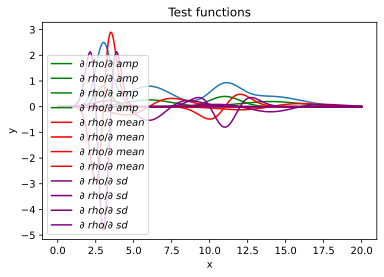

In [5]:
fig, ax = plt.subplots();
# styles = ['-','--','-.']
ax.plot(x, y, '-');
for d_amp in dy_da:
  ax.plot(x,d_amp,'-', label='$\partial\ rho / \partial\ amp$', color = 'green');
for d_mean in dy_dm:
  ax.plot(x,d_mean,'-', label='$\partial\ rho / \partial\ mean$', color = 'red');
for d_sd in dy_ds:
  ax.plot(x,d_sd,'-', label='$\partial\ rho / \partial\ sd$', color = 'purple');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Test functions")
ax.legend()
plt.show()

### Initial Estimates and Peak Finding

Root finding methods require initial estimates in most instances. The role of the **peakFinder** class described below is to identify inflection points using the second derivative of the trace.

In [6]:
class peakFinder:
  class peak:
    index       = 0
    estimate    = 1.0
    def __init__(self, _index_, _estimate_):
      self.index    = _index_
      self.estimate = _estimate_
  peaks       = []
  inflections = []
  def find_peaks (self, x):
    index = 0
    d_x   = x[1:len(x-1)]
    d_x2  = d_x[1:len(x-1)]
    d_x3  = d_x2[1:len(x-1)]
    d_y   = np.diff(y)
    d_y2  = np.diff(d_y)
    d_y3  = np.diff(d_y2)
    while index != (len(d_y3)-1):
      if d_y3[index] < 0 and d_y3[index+1] > 0:
        self.peaks.append(self.peak(index,d_x3[index]))
      index+=1
    self.inflections = d_y2.copy();
    def get_peaks (self):
      return self.peaks
    def get_inflections(self):
      return self.inflections

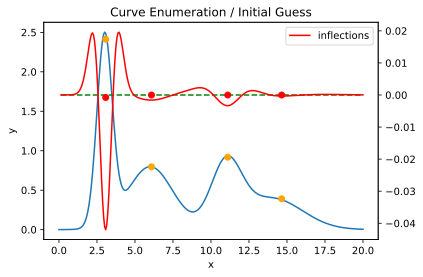

In [7]:
PF    = peakFinder()
PF.find_peaks(x)

d_x   = x[1:len(x-1)]
d_x2  = d_x[1:len(x-1)]
d_x3  = d_x2[1:len(x-1)]
d_y   = np.diff(y)
d_y2  = np.diff(d_y)
d_y3  = np.diff(d_y2)

mean_est = []
mean_inx = []
index = 0

# while index != len(d_y2):
#   if d_y2[index] < 0:
#     start = index
#     while d_y2[index] < 0:
#       index+=1
#     min_index = start;
#     for sub_i in range(start,index):
#       if d_y2[sub_i] < d_y2[min_index]:
#         min_index = sub_i;
#     mean_inx.append(min_index)
#     mean_est.append(d_x2[min_index]);
#   else:
#     index+=1
#ALTERNATIVE METHODS
while index != (len(d_y3)-1):
  if d_y3[index] < 0 and d_y3[index+1] > 0:
    mean_inx.append(index)
    mean_est.append(d_x3[index])
  index+=1

fig, ax = plt.subplots();
ax.plot(x, y, '-');
# ax.plot(d_x, d_y,'-', label = 'dy_dx');
ax2 = plt.twinx()
ax2.plot(d_x2, [0]*d_x2,'--', color = 'green')
ax2.plot(d_x2, d_y2, '-', color = 'red', label = 'inflections');
ax.plot(mean_est, y[mean_inx] , 'o', color = 'orange')
ax2.plot(mean_est, d_y3[mean_inx] , 'o', color = 'red')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Curve Enumeration / Initial Guess")
ax2.legend()
plt.show()

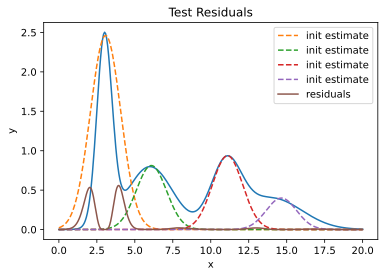

In [8]:
y_rn      = y.copy()#+np.random.normal(0,.02,300)
CL = curve_list()
CL.set_x_array(x)
CL.set_y_array(y_rn)
for index in range(0,len(mean_est)) : 
  CL.add_blank_curve()
  C       = CL.back()
  C.mean  = mean_est[index]
  C.amp   = y_rn[mean_inx[index]]/conv_norm_dist(x,[[1.0,mean_est[index],1.0]])[mean_inx[index]]
y_est     = [0] * len(x)
residuals = y_rn.copy()
fig, ax = plt.subplots();
ax.plot(x, y, '-');
for C in CL:
  ax.plot(x, C.normal_dist(x),'--', label = 'init estimate');
ax.plot(x, CL.get_residuals(), '-', label = 'residuals');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Test Residuals")
ax.legend()
plt.show()

### Defining the Jacobian

The Jacobian matrix is defined as follows:
$$ J = \left[
\begin{aligned}
&\frac{\partial r_0}{\partial \alpha_1},\frac{\partial r_1}{\partial \alpha_1},\frac{\partial r_2}{\partial \alpha_1},\dots,&\frac{\partial r_N}{\partial \alpha_1} \\
&\frac{\partial r_0}{\partial \mu_1},\frac{\partial r_1}{\partial \mu_1},\frac{\partial r_2}{\partial \mu_1},\dots, &\frac{\partial r_N}{\partial \mu_1}\\
&\frac{\partial r_0}{\partial \sigma_1},\frac{\partial r_1}{\partial \sigma_1},\frac{\partial r_2}{\partial \sigma_1},\dots, &\frac{\partial r_N}{\partial \sigma_1}\\
&\vdots &\vdots\\
&\frac{\partial r_0}{\partial \sigma_M},\frac{\partial r_1}{\partial \sigma_M},\frac{\partial r_2}{\partial \sigma_M},\dots, &\frac{\partial r_N}{\partial \sigma_M}
\end{aligned}
\right]
 $$

 For $M$ curves and $M\cdot3$ vertical entries. The total dimensions of the Jacobian are $[N x 3M]$ where $M*3 \leq N$.
 

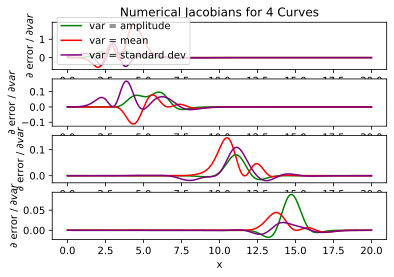

In [9]:
# residuals(y,x,(param_est[0][0],param_est[0][1],param_est[0][2]))
np.sum(CL.get_residuals())
fig, ax = plt.subplots(CL.n_curves);
ax[0].set_title("Numerical Jacobians for "+str(len(CL.curves))+" Curves");
ax[CL.n_curves-1].set_xlabel("x")
# J = CL.get_jacobian()
J = CL.get_nJacobian(1.0)
for index in range(0,CL.n_curves):
  ax_ = ax[index]
  ax_.plot(x, J[index*3], '-', label = 'var = amplitude', color = 'green');
  ax_.plot(x, J[index*3+1], '-', label = 'var = mean', color = 'red');
  ax_.plot(x, J[index*3+2], '-', label = 'var = standard dev', color = 'purple')
  ax_.set_ylabel("$\partial$ error / $\partial var$")
ax[0].legend()
plt.show()

The Newton Gauss Method iteratively finds the root of the derivative of the error ($\ ^{dr}/_{d\rho} = 0$) by estimating the change needed in the gaussian ($\Delta\rho$), which in and of itself is a function of $\Delta\alpha$, $\Delta\mu$, and $\Delta\sigma$. The Jacobian is convolved with its transpose ($J^TJ$) to acount for the fact we have calculated partial derivatives, and the Jacobian, multiplied by the residuals (i.e. the gradient $\nabla = J^T\cdot r$), is divided by this matrix. 

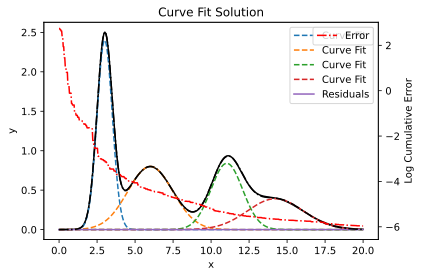

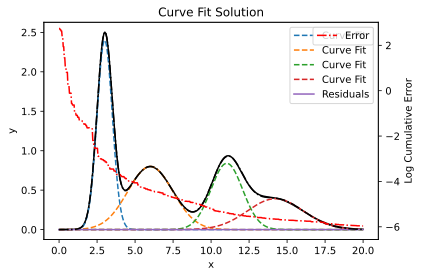

In [10]:
import time
r     = CL.get_residuals()
error = [np.sum(r)];
mu    = error[0]
step  = 1.0

# Figure preparation
fig, ax = plt.subplots();
_disp = dsp.display("", display_id=True)
ax.plot(x, y, '-k');
comb  = [0]*len(x)
for C in CL:
  comb += C.normal_dist(x)
  ax.plot(x, C.normal_dist(x),'--', label = 'Curve Fit');
ax.plot(x, CL.get_residuals(), '-', label = 'Residuals');
ax.plot(x, comb, '-.k')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Curve Fit Solution")
ax.legend()
ax2 = plt.twinx()
ax2.plot(np.linspace(0,x.max(),len(error)),np.log(error), '-.', color = 'red', label = 'Error')
ax2.set_ylabel("Log Cumulative Error")
ax2.legend()
_disp.update(fig)

while True:
  _e = error[len(error)-1]
  error.append(np.sum(CL.get_residuals()));
  J = CL.get_nJacobian(step)
  # J = CL.get_jacobian()
  JtJ = np.matmul(J,J.transpose())
  JtJ_i = np.linalg.inv(JtJ+mu*np.identity(len(JtJ)))      # Get psudo-Hessian inverse matrix
  g_r   = np.matmul(J,r)                                      # Get the gradient
  deltas = np.matmul(g_r,JtJ_i)                               # Multiply the inverse Hessian by gradient
  # deltas
  if (CL.update_curves(deltas)):
    r = CL.get_residuals()
    error.append(np.sum(r))
    # mu = error[len(error)-1]*0.1
    # mu = error[len(error)-2] - error[len(error)-1]
    mu  /= 3.0
    if (step < 1):
      step *= 2
    
    total = [0]*len(x)
    for CI in range (0,len(CL.curves)):
      trace = CL[CI].normal_dist(x)
      total += trace
      ax.lines[CI+1].set_ydata(trace)
    ax.lines[len(CL.curves)+1].set_ydata(CL.get_residuals())
    ax.lines[len(CL.curves)+2].set_ydata(total)
    ax2.lines[0].set_xdata(np.linspace(0,x.max(),len(error)))
    ax2.lines[0].set_ydata(np.log(error))
    ax2.set_ylim(np.log(error[len(error)-1])*1.1,np.log(error[0])*1.1)
    _disp.update(fig)
  else:
    mu    *= 2 
    step  /= 2
    if (step < 1E-15):
      break

''

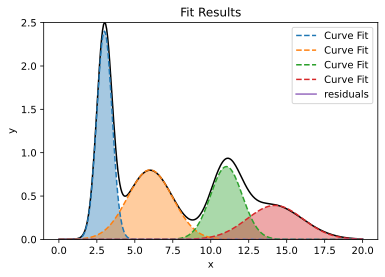

Curve 0 Result:
	Amplitude:	3.016126103997332
	Mean:		3.0005133994875828
	StdDev:		0.5010600019118603


Curve 1 Result:
	Amplitude:	2.9739380624300353
	Mean:		6.004136835109565
	StdDev:		1.4804491679932263


Curve 2 Result:
	Amplitude:	2.196944211015602
	Mean:		11.031575891384392
	StdDev:		1.0435454906139818


Curve 3 Result:
	Amplitude:	1.799692902837512
	Mean:		14.227885683815636
	StdDev:		1.8323152931067257




In [11]:
fig, ax = plt.subplots();
_disp = dsp.display("", display_id=True)
ax.plot(x, y, '-', color = 'black');
for C in CL:
  ax.plot(x, C.normal_dist(x),'--', label = 'Curve Fit');
  ax.fill_between(x, C.normal_dist(x), alpha = 0.4)

ax.plot(x, CL.get_residuals(), '-', label = 'residuals');
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(0,y_rn.max())
ax.set_title("Fit Results")
ax.legend()
plt.show()

for index in range(0, len(CL.curves)):
  C = CL[index]
  print("Curve "+ str(index)+" Result:"+
        "\n\tAmplitude:\t"+str(C.amp)+
        "\n\tMean:\t\t"+str(C.mean)+
        "\n\tStdDev:\t\t"+str(C.sd)+"\n\n")